# AlexNet, A Deep Learning Breakthrough 
## ImageNet Classification with Deep Convolutional Neural Networks

Authors : Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton

![](https://cdn-images-1.medium.com/max/1536/1*qyc21qM0oxWEuRaj-XJKcw.png)

<p>This was one of the most influential publication in the field of Computer Vision.This model won the ILSVRC 2012 Competition. </p>


<pre>
1.Trained the network on ImageNet data which contained over 15 million images form over 22,000 categories.
2. This paper uses ReLU activation function for non linearity. ReLU was found to decresase the run time of training , as it was faster than conventional tanh function.
3. Dropout was implemented to reduce the effect of overfitting.
4. Data Augumentation technique was used that consisted of image translation, patch extraction and image reflection.
5. Stochastic Gradient Descent was used as optimizer with momentum and weight decay.
6. This model was trained on GTX 580 GPUs for aroung 6 days.

</pre>


## Dataset
Imagenet is a dataset of over 15 million images belonging to roughlt 22,000 categories.The images were collected from the web and labeled by human labelers using Amazon’s Mechanical Turk crowd-sourcing tool. Starting in 2010, as part of the Pascal Visual Object Challenge, an annual competition called the ImageNet Large-Scale Visual Recognition Challenge
(ILSVRC) has been held. ILSVRC uses a subset of ImageNet with roughly 1000 images in each of
1000 categories. In all, there are roughly 1.2 million training images, 50,000 validation images, and
150,000 testing images.

Due to computational reasons, we will use CIFAR-10 Dataset in this paper implementation.

## Architecture

### ReLU Nonlinearity

The standard way of implementing neuron's output before this paper was to use tanh activation.
![](https://cdn-images-1.medium.com/max/1600/1*Xu7B5y9gp0iL5ooBj7LtWw.png)

![](https://cdn-images-1.medium.com/max/937/1*oePAhrm74RNnNEolprmTaQ.png)

It was observed that the training time of tanh activation function was bigger than that of ReLU activation during backpropagation step in gradient descent optimization.

[Krizhevsky relu vs tanh](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)

![tanh vs relu](http://cs231n.github.io/assets/nn1/alexplot.jpeg)

solid line - ReLU

dashed line - tanh



#### ReLU in Numpy

In [4]:
import numpy as np

def ReLU(x):
  return abs(x) * (x > 0)

x = np.array([1,-1, -0.5, 0.32])
ReLU(x)

array([1.  , 0.  , 0.  , 0.32])

#### ReLU in Pytorch

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [6]:
import torch

relu = torch.nn.ReLU()

x = torch.tensor(x) # x = numpy array of [1,-1, -0.5, 0.32]
relu(x)

tensor([1.0000, 0.0000, 0.0000, 0.3200], dtype=torch.float64)

### Local Response Normalization

Relu has this desirable property that they do not need input normalization to prevent them from saturating. Learning will occur through ReLU even if some of the training data predoce positive input. However it is still observed that Local Response Normalization helps in generalization.

![](https://i.stack.imgur.com/MfHgA.gif)

![](https://qph.fs.quoracdn.net/main-qimg-5121f4aac5305e50dbe19bf1aeab0a90)



#### Local Response Normalization in Pytorch


In [0]:
import torch.nn as nn

class LRN(nn.Module):
  def __init__(self, size, alpha=1e-4, beta=0.75, k=1):
    super(LRN, self).__init__()
    self.avg = nn.AvgPool3d(kernel_size =(size,1,1), stride=1, padding=int((size-1)/2))
    self.alpha = alpha
    self.beta = beta
    self.k = k
    
  def forward(self, x):
    deno = x.pow(2).unsqueeze(1)
    deno = self.avg(deno).squeeze(1)
    deno = deno.mul(self.alpha).add(self.k).pow(self.beta)
    x = x.div(deno)
    return x 

In [71]:
x = torch.randn( 20,3, 10, 10)
lrn = torch.nn.LocalResponseNorm(2)
lrn(x).size()

torch.Size([20, 3, 10, 10])

### Architecture

In [0]:
class AlexNet(nn.Module):
  def __init__(self, classes=1000):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, classes),
    )
  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), 256 * 6 * 6)
      x = self.classifier(x)
      return x
    
    
  

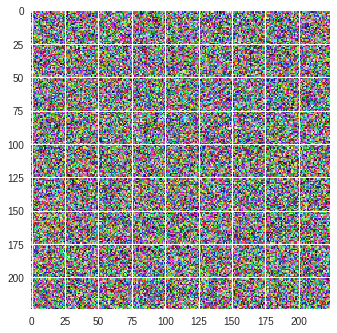

In [83]:
import pylab as plt

x = torch.randn(1, 3, 224, 224).uniform_(0, 1)
im = plt.imshow(x.squeeze().permute(1, 2, 0).numpy())
plt.show()

In [88]:
alexnet = AlexNet()
alexnet(x).size()

torch.Size([1, 1000])

### Reducing Overfitting

#### Data Augmentation
The easiest way to avoid over fitting is to increase the data size, so that the model can learn more generalized features of the data.

But getting more data is always not an easy task , so one of the way of getting more data is to artificially generate more data from the given data.

![](https://cdn-images-1.medium.com/max/1020/1*C8hNiOqur4OJyEZmC7OnzQ.png)

![](https://cdn-images-1.medium.com/max/1600/1*zArgCkIEszPa0RV7cTKVbg.png)

There are many types of data augmentation techniques available

1. Flip (horizontal and vertical)

2. Rotation

3. Scaling

4. Crop

5. Translation

6. Gaussian noise


#### Data Augumentation in Python

In [91]:
!pip install -U Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (5.3.0)


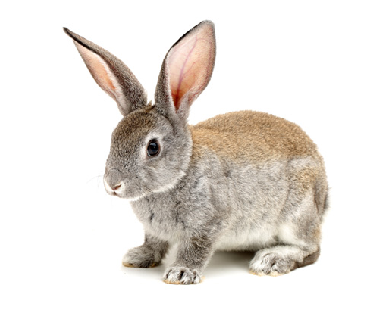

In [8]:
from skimage import io
import matplotlib.pyplot as plt

image = io.imread('https://cdn3.bigcommerce.com/s-nadnq/product_images/uploaded_images/20.jpg')

plt.imshow(image)
plt.grid(False)
plt.axis('off')
plt.show()

In [0]:

import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    return image_array[::-1, :]

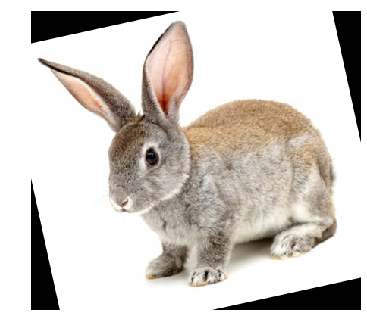

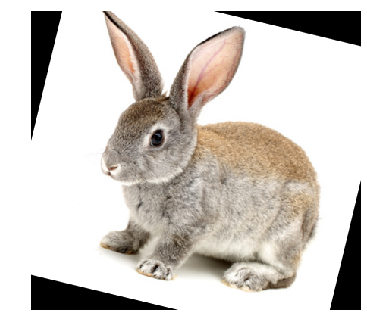

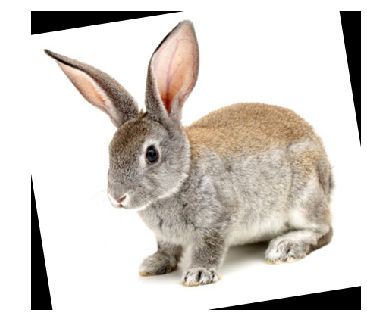

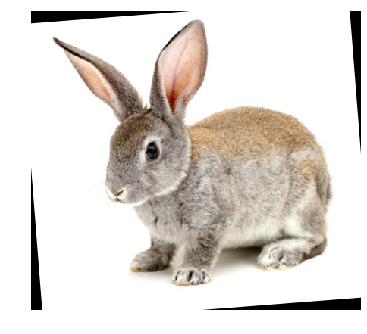

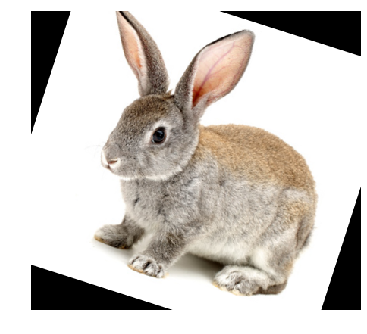

In [22]:
for _ in range(5):
  plt.imshow(random_rotation(image))
  plt.grid(False)
  plt.axis('off')
  plt.show()

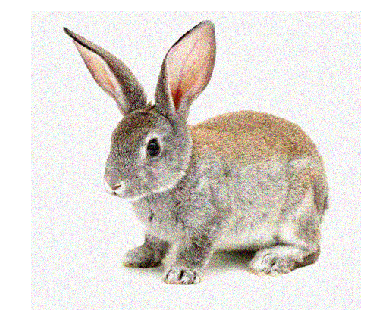

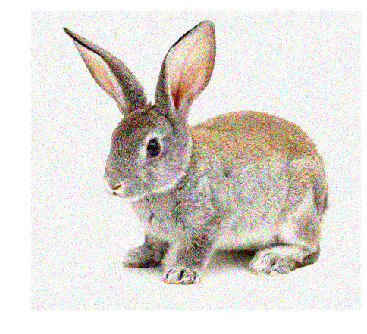

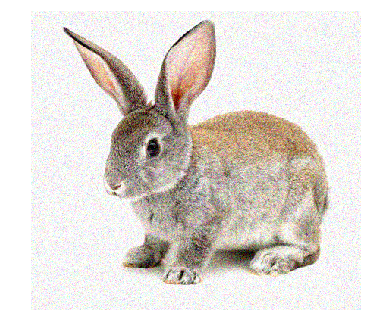

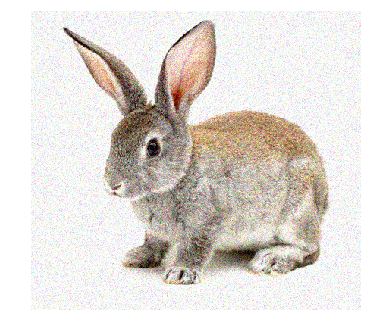

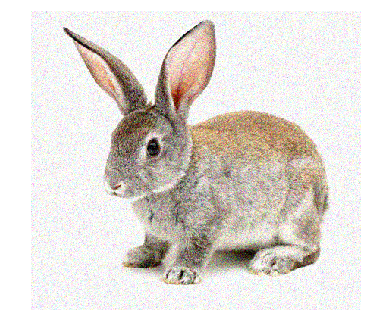

In [23]:
for _ in range(5):
  plt.imshow(random_noise(image))
  plt.grid(False)
  plt.axis('off')
  plt.show()

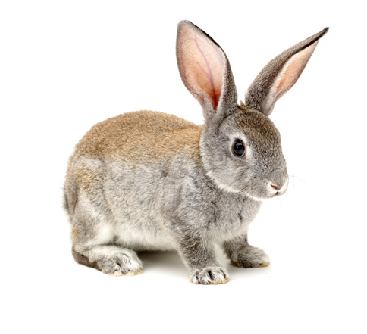

In [25]:

plt.imshow(horizontal_flip(image))
plt.grid(False)
plt.axis('off')
plt.show()

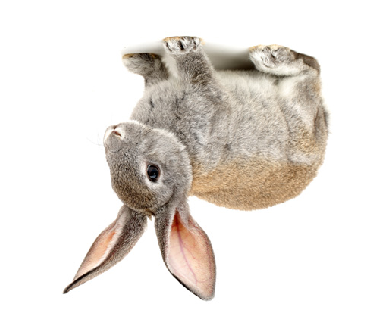

In [27]:

plt.imshow(vertical_flip(image))
plt.grid(False)
plt.axis('off')
plt.show()

### Dropout 

This technique reduces complex co-adaptations of neurons,
since a neuron cannot rely on the presence of particular other neurons. It is, therefore, forced to
learn more robust features that are useful in conjunction with many different random subsets of the
other neurons. At test time, we use all the neurons but multiply their outputs by 0.5, which is a
reasonable approximation to taking the geometric mean of the predictive distributions produced by
the exponentially-many dropout networks.

![](https://www.learnopencv.com/wp-content/uploads/2018/06/dropoutAnimation.gif)



#### Dropout in Numpy

In [36]:
def dropout(X, drop_probability):
    keep_probability = 1 - drop_probability
    mask = np.random.uniform(0, 1.0, X.shape) < keep_probability
    if keep_probability > 0.0:
        scale = (1/keep_probability)
    else:
        scale = 0.0
    return mask * X * scale
  
  
  
x = np.random.randn(3,3)
dropout(x, 0.3)

array([[ 0.        ,  2.12769017, -1.95883643],
       [ 0.05583112, -0.51280684,  0.        ],
       [-1.64030713,  3.15857694,  1.13236446]])

#### Dropout in Pytorch

In [45]:
import torch

x = np.random.randn(3,3)
x_tensor = torch.from_numpy(x)

dropout = torch.nn.Dropout(0.5)
dropout(x_tensor)

tensor([[ 0.9667,  0.0000,  2.1510],
        [ 1.4301,  0.0000,  1.4544],
        [-0.0000,  1.3651, -0.0000]], dtype=torch.float64)

### Learning

Gradient Descent optimizer with momentim of 0.9 and weight decay of 0.0005 is used. Batch size of 128.

#### Weight/ bias initializers
 Weight in each layer is initialized from a zero mean Gaussian Distribution with standard deviation 0.01. bias was initialized with 1.

#### lr scheduler
manual adjusting of learning rates and lr was reduced when loss stopped increasing.

#### Weight / bias initialiser with Numpy



In [47]:
weights = np.random.normal(loc=0.0, scale=0.01, size=(3,3))
weights

array([[-0.00723783, -0.00436599,  0.00199946],
       [-0.00618118, -0.00122866,  0.00844244],
       [ 0.01453114,  0.00025038, -0.00534145]])

In [56]:
bias = np.ones(3)
bias

array([1., 1., 1.])

In [66]:
X = np.random.rand(3,3)
print('Input X  = \n',X)

w = np.random.normal(loc=0.0, scale=0.01, size=(3,1))
print('\nInitialized weight w = \n',w)

bias = np.ones((3,1))
print('\nInitialized bias b = \n',bias)

Input X  = 
 [[0.9769654  0.91344693 0.26452228]
 [0.24474425 0.75985733 0.0462379 ]
 [0.80824044 0.9641414  0.89342702]]

Initialized weight w = 
 [[-0.00945599]
 [-0.00674226]
 [ 0.00975576]]

Initialized bias b = 
 [[1.]
 [1.]
 [1.]]


In [68]:
z = np.dot(X, w) + bias
z

array([[0.98718374],
       [0.99301363],
       [0.99457285]])